In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('news_data.csv') ##  Loading the dataset
df.head()

,publish_date,category,title,url,content
0,2017-01-07,etf_news,Bitcoin growing as an escapist safe haven,http://www.heraldandnews.com/members/forum/wir...,NaN
1,2017-01-08,etf_news,Bitcoin grows as an escapist safe haven : Bloo...,http://www.oregonlive.com/opinion/index.ssf/20...,BITCOIN.JPG\n\nThis 2013 file photo shows bitc...
2,2017-01-08,geopolitical_events,Why Is It Almost Impossible in India to Hoard ...,http://www.newsbtc.com/2017/01/08/india-black-...,India has been in the news quite often these d...
3,2017-01-09,exchange_news,"Bitcoin Price Was Volatile Last Week , But Not...",http://www.forbes.com/sites/laurashin/2017/01/...,NaN
4,2017-01-10,exchange_news,Bitstamp Announces the Inclusion of Ripple Alo...,http://www.newsbtc.com/2017/01/10/bitstamp-add...,"Bitstamp, one of the leading cryptocurrency ex..."


In [3]:
df['content'].isna().value_counts()

content
False    9644
True     5052
Name: count, dtype: int64

In [4]:
### There are alot of missing values for content, so its better to just drop these rows
df.dropna(subset='content', inplace=True)

In [5]:
### URL was initially used to scrape the content, its no longer needed 
df.drop('url', axis=1, inplace=True)

In [6]:
df.set_index('publish_date', inplace=True)

In [7]:
df.head()

,category,title,content
publish_date,,,
2017-01-08,etf_news,Bitcoin grows as an escapist safe haven : Bloo...,BITCOIN.JPG\n\nThis 2013 file photo shows bitc...
2017-01-08,geopolitical_events,Why Is It Almost Impossible in India to Hoard ...,India has been in the news quite often these d...
2017-01-10,exchange_news,Bitstamp Announces the Inclusion of Ripple Alo...,"Bitstamp, one of the leading cryptocurrency ex..."
2017-01-10,macro_economic_trends,Georgia to Store Real Estate Documents in Bloc...,The country of Georgia will introduce Blockcha...
2017-01-10,etf_news,Report : Bitcoin ETF Could Amass $300 Million ...,Report: Bitcoin ETF Could Amass $300 Million i...


## 1. Cleaning the Data

In [22]:
cleaned_df = df.copy()

In [23]:
from text_utils import clean_text
cleaned_df['content'] = cleaned_df['content'].apply(clean_text)

In [27]:
cleaned_df['content'].iloc[0]

'bitcoin jpg file photo show bitcoin token sandy utah ap photo file leonid bershidsky bitcoin worth first time since crossed line briefly one considers currency open debate would best performing one world last month gained percent u dollar donald trump like phenomenon finance show rising demand alternative traditional money despite rising price profile bitcoin still something toy currency rarely logged daily transaction significantly fewer croatia national clearing system register country currency kuna number merchant accepting bitcoin growing still extremely challenging use principle currency wherever live practical purpose useful mostly people seeking bypass country currency restriction chinese example venezuelan according coin dance last year average weekly bitcoin trading volume quadrupled venezuela bitcoin trading volume chinese yuan currency responsible percent bitcoin trading double year ago according cryptocompare point however rally breaking restrictive market speculator drivi

## 2. Loading and Configuring FinBERT

In [29]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch


tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [30]:
def  get_token_length(text, tokenizer):
    """
    Helper method to get the length of tokenize sequence, 
    in order to make informed decision regarding max_length while encoding
    """
    tokens = tokenizer.encode(text, add_special_tokens=True)
    return len(tokens)
    

cleaned_df['token_length'] = cleaned_df['content'].apply(lambda x: get_token_length(x, tokenizer))


In [31]:
import matplotlib.pyplot as plt

desc = cleaned_df['token_length'].describe()
desc

count     9644.000000
mean       429.687059
std        549.446915
min          2.000000
25%        186.000000
50%        329.000000
75%        508.000000
max      11844.000000
Name: token_length, dtype: float64

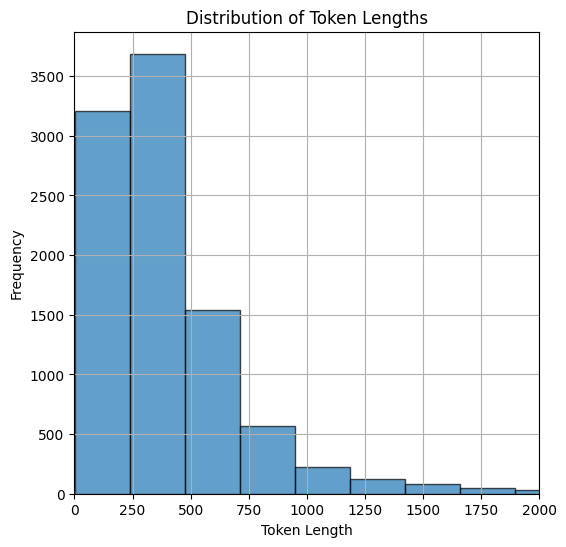

In [48]:
plt.figure(figsize=(6,6))
plt.hist(cleaned_df['token_length'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.xlim(0, 2000)
plt.ylabel('Frequency')
plt.grid(True)
plt.show();


In [44]:
import numpy as np

percentiles = {f'percentile_{x}' : np.percentile(cleaned_df['token_length'], x) for x in [95, 90, 85, 80]}
print(percentiles)

{'percentile_95': 1081.7000000000007, 'percentile_90': 788.0, 'percentile_85': 645.5499999999993, 'percentile_80': 563.0}


In [50]:
### Choosing the value near 80th percentile, as it captures alot of detail, but also reducing the computational costs
from text_utils import get_sentiment
cleaned_df['sentiment'] = cleaned_df['content'].apply(lambda x: get_sentiment(x, tokenizer, model, max_length=512))

In [52]:
sentiment_scores = cleaned_df.copy()

In [56]:
sentiment_scores.head()

,category,title,content,token_length,sentiment
publish_date,,,,,
2017-01-08,etf_news,Bitcoin grows as an escapist safe haven : Bloo...,bitcoin jpg file photo show bitcoin token sand...,511,0
2017-01-08,geopolitical_events,Why Is It Almost Impossible in India to Hoard ...,india news quite often day government decided ...,349,0
2017-01-10,exchange_news,Bitstamp Announces the Inclusion of Ripple Alo...,bitstamp one leading cryptocurrency exchange p...,256,1
2017-01-10,macro_economic_trends,Georgia to Store Real Estate Documents in Bloc...,country georgia introduce blockchain technolog...,651,0
2017-01-10,etf_news,Report : Bitcoin ETF Could Amass $300 Million ...,report bitcoin etf could amass million asset a...,52,0


In [54]:
sentiment_scores['sentiment'].value_counts()

sentiment
0    6962
1    2318
2     364
Name: count, dtype: int64

In [57]:
sentiment_scores.drop(['title', 'content', 'token_length'], axis=1, inplace=True)

In [59]:
sentiment_scores = sentiment_scores.rename_axis('Date')

In [60]:
sentiment_scores.head()

,category,sentiment
Date,,
2017-01-08,etf_news,0
2017-01-08,geopolitical_events,0
2017-01-10,exchange_news,1
2017-01-10,macro_economic_trends,0
2017-01-10,etf_news,0


In [62]:
sentiment_scores['category'].unique()

array(['etf_news', 'geopolitical_events', 'exchange_news',
       'macro_economic_trends', 'blockchain_innovations',
       'market_adoption', 'regulatory_news', 'legal_actions',
       'security_enhancements', 'market_movements', 'media_coverage',
       'institutional_involvement'], dtype=object)

In [66]:
### There are multiple news on some days, but since we need only one news per day
### We need to aggregate the news sentiment for the day, in such a way it keeps 
### the high impact news category more weightage while aggregating.
### A dictionary representing various news category priorites is defined in the config.py file
from config import IMPACT_WEIGHTS
from text_utils import aggregate_sentiment

sentiment_scores = aggregate_sentiment(sentiment_scores, IMPACT_WEIGHTS)
sentiment_scores.head()

In [76]:
### Finally Saving the aggregated sentiment scores into a csv file
### So that later it can be merged with the bitcoin price data
sentiment_scores.to_csv('sentiment_scores.csv')